In [15]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
data_folder='~/data/FMNIST'
fmnist=datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images=fmnist.data
tr_target=fmnist.targets

In [18]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets


In [19]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x=x.float()/255 #normalizing dataset by dividing with max-pixel
    x=x.view(-1, 1, 28, 28) #reshaping
    self.x, self.y=x, y

  def __getitem__(self, ix):
    x, y=self.x[ix], self.y[ix]
    return x.to(device), y.to(device)

  def __len__(self):
    return len(self.x)

#@ CNN Architecture:
def ConvNet():
  model=nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3200, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
  ).to(device)

  loss_func=nn.CrossEntropyLoss()
  optimizer=Adam(model.parameters(), lr=1e-3)
  return model, loss_func, optimizer

def train_batch(x, y, model, opt, loss_func):
    prediction = model(x) #forward pass
    batch_loss = loss_func(prediction, y) #loss Calculation
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()



@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [20]:
def get_data():
    train = FMNISTDataset(tr_images, tr_target)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [25]:

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_func(prediction, y)
    return val_loss.item()

In [26]:
trn_dl, val_dl = get_data()
model, loss_func, optimizer=ConvNet()

In [27]:
%pip install torch_summary
from torchsummary import summary
model, loss_func, optimizer = ConvNet()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─Conv2d: 1-3                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-4                         [-1, 128, 5, 5]           --
├─ReLU: 1-5                              [-1, 128, 5, 5]           --
├─Flatten: 1-6                           [-1, 3200]                --
├─Linear: 1-7                            [-1, 256]                 819,456
├─ReLU: 1-8                              [-1, 256]                 --
├─Linear: 1-9                            [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.87


In [28]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4


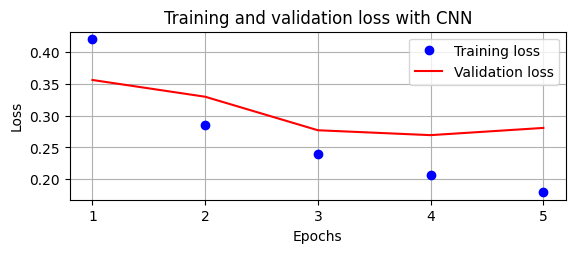

<ipython-input-29-7a9e3eea833f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


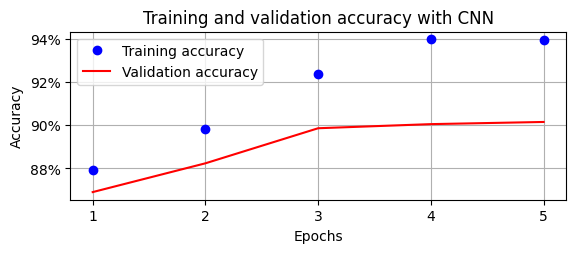

In [29]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()